In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import yfinance as yf
import sklearn
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
stock_data = yf.download('AAPL', start='2017-01-01', end='2022-10-01')
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2017-01-03  28.950001  29.082500  28.690001  29.037500  27.174753  115127600
2017-01-04  28.962500  29.127501  28.937500  29.004999  27.144339   84472400
2017-01-05  28.980000  29.215000  28.952499  29.152500  27.282375   88774400
2017-01-06  29.195000  29.540001  29.117500  29.477501  27.586527  127007600
2017-01-09  29.487499  29.857500  29.485001  29.747499  27.839207  134247600


Text(0, 0.5, 'Prices ($)')

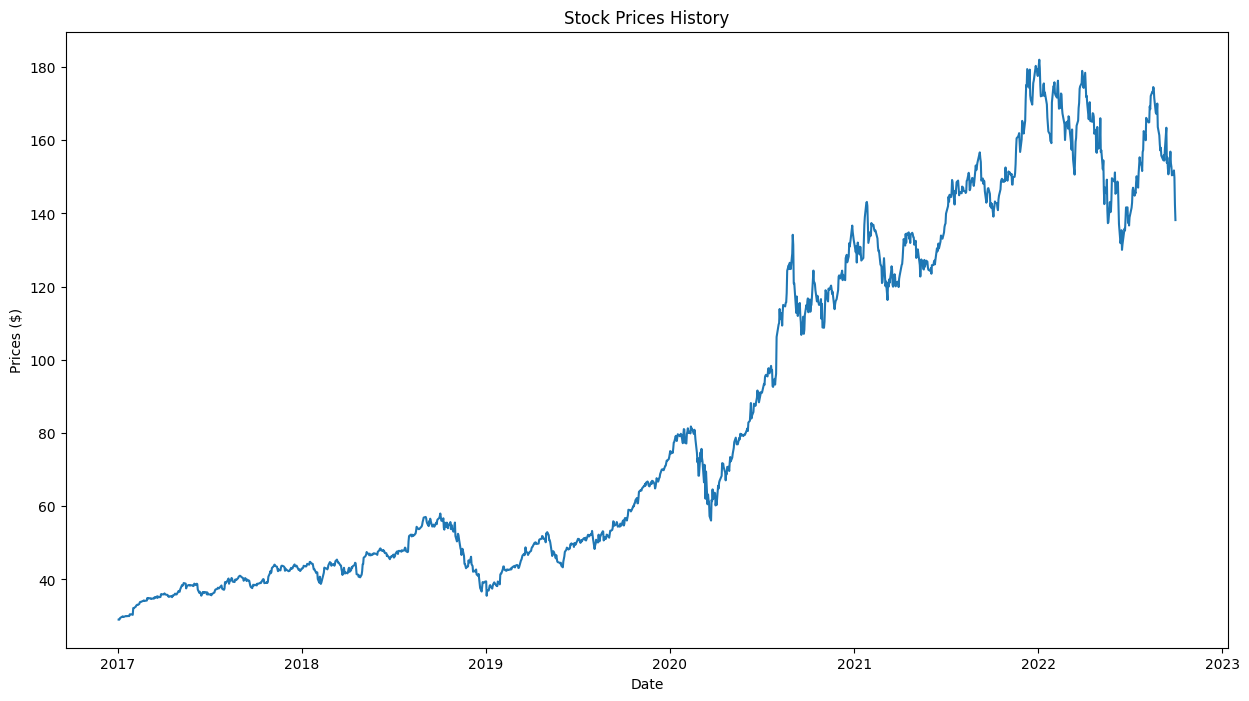

In [16]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [17]:
volume = stock_data['Volume']


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1098/1098 [==============================] - 15s 12ms/step - loss: 0.0016
Epoch 2/3
1098/1098 [==============================] - 13s 12ms/step - loss: 6.0792e-04
Epoch 3/

C:\Users\Ishaan\AppData\Local\Temp\ipykernel_7812\2716467921.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


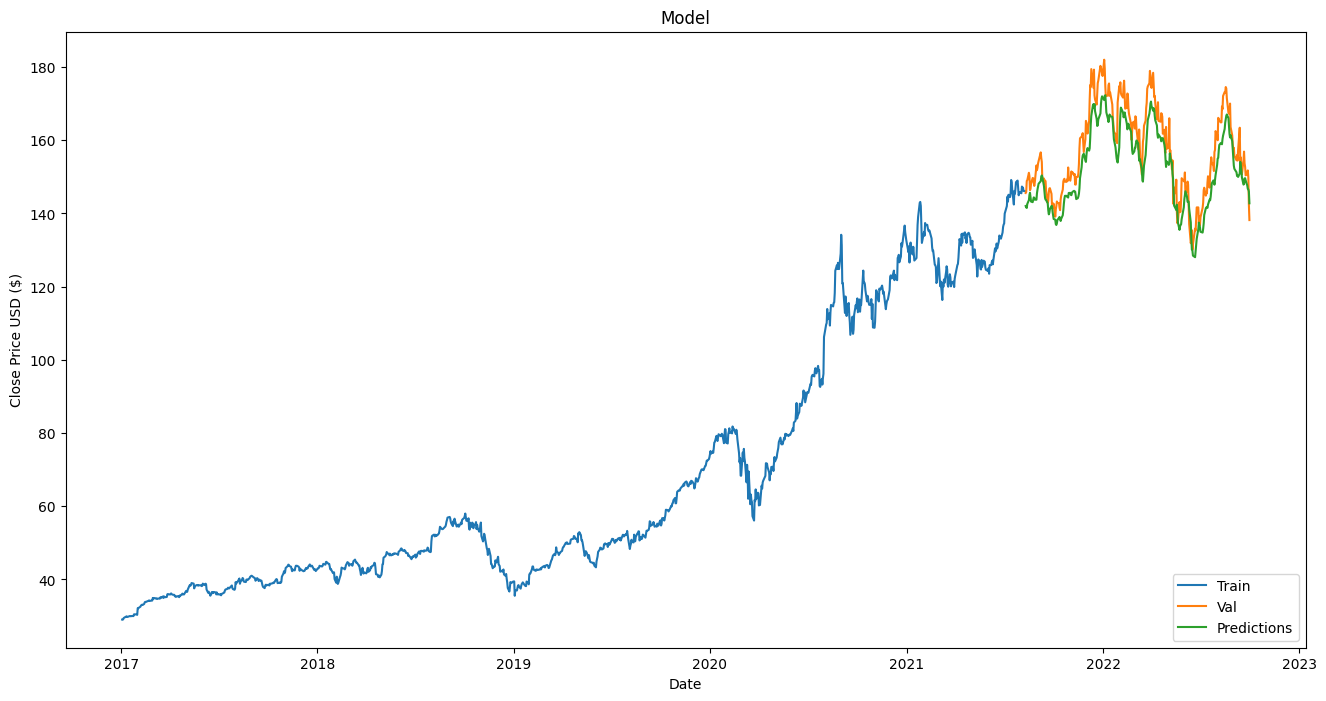

In [19]:

close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()